In [1]:
# In google colab, 
# For master version of catalyst, uncomment:
# (master version should be fully compatible with this notebook)
# ! pip install git+git://github.com/catalyst-team/catalyst.git

# For last release version of catalyst, uncomment:
# ! pip install catalyst

# For specific commit version of catalyst, uncomment:
# ! pip install git+http://github.com/catalyst-team/catalyst.git@{commit_hash}

# Segmentation

If you have Unet, all CV is segmentation now.

## Goals

- train Unet on isbi dataset
- visualize the predictions

# Preparation

%%bash 

# Get the data:
function gdrive_download () {
  CONFIRM=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=$1" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')
  wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$CONFIRM&id=$1" -O $2
  rm -rf /tmp/cookies.txt
}

mkdir -p data
gdrive_download 1N82zh0kzmnzqRvUyMgVOGsCoS1kHf3RP ./data/isbi.tar.gz
tar -xf ./data/isbi.tar.gz -C ./data/

Final folder structure with training data:
```bash
catalyst-examples/
    data/
        isbi/
            train-volume.tif
            train-labels.tif
```

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Data

In [3]:
# ! pip install tifffile

In [4]:
import tifffile as tiff

images = tiff.imread('./data/isbi/train-volume.tif')
masks = tiff.imread('./data/isbi/train-labels.tif')

data = list(zip(images, masks))

train_data = data[:-4]
valid_data = data[-4:]

In [5]:
import collections
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from catalyst.data import Augmentor
from catalyst.dl import utils

bs = 4
num_workers = 4

data_transform = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 255.).unsqueeze_(0)),
    Augmentor(
        dict_key="features",
        augment_fn=transforms.Normalize(
            (0.5, ),
            (0.5, ))),
    Augmentor(
        dict_key="targets",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 255.).unsqueeze_(0))
])

open_fn = lambda x: {"features": x[0], "targets": x[1]}

loaders = collections.OrderedDict()

train_loader = utils.get_loader(
    train_data, 
    open_fn=open_fn, 
    dict_transform=data_transform, 
    batch_size=bs, 
    num_workers=num_workers, 
    shuffle=True)

valid_loader = utils.get_loader(
    valid_data, 
    open_fn=open_fn, 
    dict_transform=data_transform, 
    batch_size=bs, 
    num_workers=num_workers, 
    shuffle=False)

loaders["train"] = train_loader
loaders["valid"] = valid_loader

# Model

In [6]:
from catalyst.contrib.models.segmentation import Unet

# Train

In [7]:
import torch
import torch.nn as nn
from catalyst.dl.runner import SupervisedRunner

# experiment setup
num_epochs = 50
logdir = "./logs/segmentation_notebook"

# model, criterion, optimizer
model = Unet(num_classes=1, in_channels=1, num_channels=64, num_blocks=4)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 40], gamma=0.3)


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.57it/s, loss=0.468]
1/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.24it/s, loss=31.837]
[2019-12-20 04:55:40,067] 
1/50 * Epoch 1 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=553.0794 | _timers/batch_time=0.0333 | _timers/data_time=0.0207 | _timers/model_time=0.0126 | loss=0.5762
1/50 * Epoch 1 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=28.8543 | _timers/batch_time=0.1386 | _timers/data_time=0.1287 | _timers/model_time=0.0097 | loss=31.8374
2/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.57it/s, loss=0.379]
2/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.28it/s, loss=2.026]
[2019-12-20 04:55:52,588] 
2/50 * Epoch 2 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=543.4500 | _timers/batch_time=0.0313 | _timers/data_time=0.0235 | _timers/model_time=0.0077 | loss=0.4092
2/50 * Epoch 2 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=30.0130 | _timers/batch_time=0.1333 | _

17/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.58it/s, loss=0.193]
17/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.24it/s, loss=0.221]
[2019-12-20 04:58:33,846] 
17/50 * Epoch 17 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=536.5106 | _timers/batch_time=0.0296 | _timers/data_time=0.0221 | _timers/model_time=0.0074 | loss=0.2049
17/50 * Epoch 17 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=27.9169 | _timers/batch_time=0.1433 | _timers/data_time=0.1341 | _timers/model_time=0.0090 | loss=0.2213
18/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.56it/s, loss=0.201]
18/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.09it/s, loss=0.202]
[2019-12-20 04:58:45,596] 
18/50 * Epoch 18 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=539.3425 | _timers/batch_time=0.0308 | _timers/data_time=0.0233 | _timers/model_time=0.0074 | loss=0.2009
18/50 * Epoch 18 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.6066 | _timers/batch_time=

32/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.28it/s, loss=0.193]
[2019-12-20 05:00:51,345] 
32/50 * Epoch 32 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=573.7912 | _timers/batch_time=0.0276 | _timers/data_time=0.0209 | _timers/model_time=0.0066 | loss=0.1752
32/50 * Epoch 32 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=28.9297 | _timers/batch_time=0.1383 | _timers/data_time=0.1294 | _timers/model_time=0.0086 | loss=0.1934
33/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.56it/s, loss=0.188]
33/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.31it/s, loss=0.216]
[2019-12-20 05:00:58,894] 
33/50 * Epoch 33 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=532.6151 | _timers/batch_time=0.0311 | _timers/data_time=0.0235 | _timers/model_time=0.0075 | loss=0.1812
33/50 * Epoch 33 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=29.5902 | _timers/batch_time=0.1352 | _timers/data_time=0.1281 | _timers/model_time=0.0070 | loss=

48/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.55it/s, loss=0.158]
48/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.31it/s, loss=0.193]
[2019-12-20 05:02:58,069] 
48/50 * Epoch 48 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=556.7206 | _timers/batch_time=0.0298 | _timers/data_time=0.0224 | _timers/model_time=0.0073 | loss=0.1504
48/50 * Epoch 48 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=30.1712 | _timers/batch_time=0.1326 | _timers/data_time=0.1258 | _timers/model_time=0.0066 | loss=0.1927
49/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.54it/s, loss=0.154]
49/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.01it/s, loss=0.195]
[2019-12-20 05:03:05,664] 
49/50 * Epoch 49 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=547.7546 | _timers/batch_time=0.0303 | _timers/data_time=0.0228 | _timers/model_time=0.0074 | loss=0.1521
49/50 * Epoch 49 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=24.8198 | _timers/batch_time=

# Inference

In [8]:
runner_out = runner.predict_loader(
    model, loaders["valid"], resume=f"{logdir}/checkpoints/best.pth"
)

=> loading checkpoint ./logs/segmentation_notebook/checkpoints/best.pth
loaded checkpoint ./logs/segmentation_notebook/checkpoints/best.pth (epoch 36)
Top best models:



# Predictions visualization

In [9]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

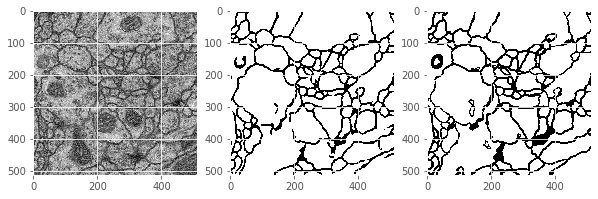

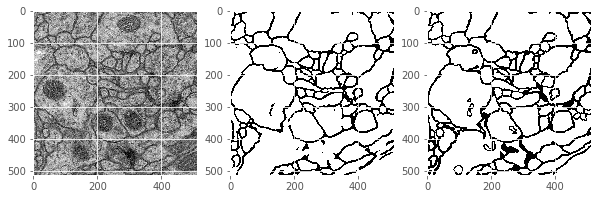

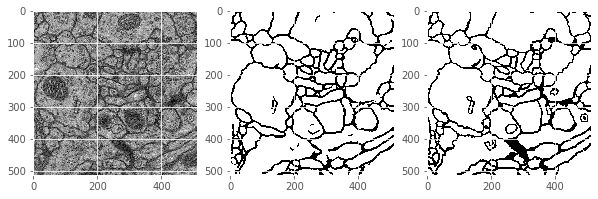

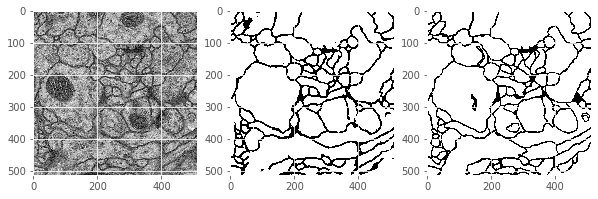

In [10]:
sigmoid = lambda x: 1/(1 + np.exp(-x))

for i, (input, output) in enumerate(zip(valid_data, runner_out)):
    image, mask = input
    
    threshold = 0.5
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, 'gray')
    
    plt.subplot(1, 3, 2)
    output = sigmoid(output[0].copy())
    output = (output > threshold).astype(np.uint8)
    plt.imshow(output, 'gray')
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, 'gray')
    
    plt.show()